# Inference: Single Image Test

This notebook demonstrates a minimal inference pipeline required by the project submission. (one-image-test) It:

1. Loads one image/sample from the test set.
2. Loads trained parameters from the best model checkpoint.
3. Runs inference on the selected image.
4. Displays the predicted EUNIS class.

Update the **User settings** cell to point to your trained checkpoint and (optionally) a specific image ID.

## Setup

Import dependencies and project modules. Run this cell first.

In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import rasterio
import matplotlib.pyplot as plt

# Make project imports available
PROJECT_ROOT = Path('.').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from config import IMAGE_SIZE, IMAGE_MEAN, IMAGE_STD, NUM_CLASSES
from eunis_labels import eunis_id_to_lab
from sweco_group_of_variables import sweco_variables_dict
from src.models.fusion import TabularOnlyModel, ImageOnlyModel, EarlyFusionModel, GatedFusionModel, LateFusionModel


## User Settings

- `MODE`: `tabular` or `image` or `fusion`.
- `GROUP`: required when `MODE='tabular' or 'fusion'`.
- `CHECKPOINT_PATH`: path to our trained `best.pt`.
- `IMAGE_ID`: optional; if `None`, the first test sample is used.

In [3]:
# ---- User settings ----
MODE = 'fusion'  # 'tabular' or 'image' or 'fusion'
BACKBONE = 'resnet18'  
GROUP = 'all'  # Required if MODE == 'tabular' or 'fusion' (e.g., 'bioclim')
CHECKPOINT_PATH = Path('ablation_study_results') / 'best_model.pt'
IMAGE_ID = '2496338_1117313'  # Set a specific id like '2572824_1174283' or keep None
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- Data loading ----
df = pd.read_csv('dataset_split.csv')
test_df = df[df['split'] == 'test'].reset_index(drop=True)

if IMAGE_ID is None:
    sample = test_df.iloc[0]
else:
    sample = test_df[test_df['id'] == IMAGE_ID].iloc[0]

image_path = Path('data') / f"{sample['id']}.tif"
assert image_path.exists(), f"Missing image: {image_path}"
assert CHECKPOINT_PATH.exists(), f"Missing checkpoint: {CHECKPOINT_PATH}"

# ---- Helpers ----
def normalize_image(img):
    mean = torch.tensor(IMAGE_MEAN, dtype=img.dtype, device=img.device).view(-1, 1, 1)
    std = torch.tensor(IMAGE_STD, dtype=img.dtype, device=img.device).view(-1, 1, 1)
    return (img - mean) / std

def resize_image(img, size):
    img = img.unsqueeze(0)
    img = F.interpolate(img, size=size, mode='bilinear', align_corners=False)
    return img.squeeze(0)

def resolve_group_columns(frame, group):
    if group is None:
        return None

    desired = []
    seen = set() 

    if group == "all":
        group_keys = list(sweco_variables_dict.keys())
    else:
        group_keys = [g.strip() for g in group.split(',')]

    for g_key in group_keys:
        if g_key not in sweco_variables_dict:
            raise ValueError(f"Unknown group: '{g_key}'. Options: {list(sweco_variables_dict.keys())} + ['all']")
        cols = sweco_variables_dict[g_key]
        for col in cols:
            if col not in seen:
                desired.append(col)
                seen.add(col)

    resolved = []
    for col in desired:
        if col in df.columns:
            resolved.append(col)
            continue
        # Handle duplicated column names (pandas appends .1, .2).
        matches = [c for c in df.columns if c.startswith(f"{col}.")]
        if matches:
            resolved.append(matches[0])
            continue
        raise KeyError(f"Column '{col}' not found in dataset_split.csv.")
    
    return resolved

# ---- Load image ----
with rasterio.open(image_path) as src:
    img = src.read(out_dtype='float32')

img = img[:3, :, :]
img = torch.from_numpy(img)
if img.max() > 1.5:
    img = img / 255.0
img = resize_image(img, IMAGE_SIZE)
img = normalize_image(img)
image_tensor = img.unsqueeze(0).to(DEVICE)

tabular_tensor = None
if MODE == 'fusion':
    if GROUP is None:
        raise ValueError('GROUP is required for fusion mode.')
    cols = resolve_group_columns(df, GROUP)
    tab_vals = sample[cols].to_numpy(dtype=np.float32)
    tabular_tensor = torch.from_numpy(tab_vals).unsqueeze(0).to(DEVICE)


## Inference

Build the model, load weights, and print the top prediction + top-5 probabilities.

In [5]:
# ---- Build model and load weights ----
if MODE == 'tabular':
    model = TabularOnlyModel(tabular_dim=tabular_tensor.shape[1])
elif MODE == 'image':
    model = ImageOnlyModel(BACKBONE, pretrained=False)
else:
    # model = EarlyFusionModel(BACKBONE, pretrained=False, tabular_dim=tabular_tensor.shape[1], image_size=IMAGE_SIZE)
    model = GatedFusionModel(BACKBONE, pretrained=False, tabular_dim=tabular_tensor.shape[1], image_size=IMAGE_SIZE)
    # model = LateFusionModel(BACKBONE, pretrained=False, tabular_dim=tabular_tensor.shape[1], image_size=IMAGE_SIZE)

ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.to(DEVICE)
model.eval()

# ---- Inference ----
with torch.no_grad():
    if MODE == 'tabular':
        logits = model(tabular_tensor)
    elif MODE == 'image':
        logits = model(image_tensor)
    else:
        logits = model(image_tensor, tabular_tensor)
    probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
    pred_id = int(np.argmax(probs))
    pred_label = eunis_id_to_lab[pred_id]

print(f"Prediction: {pred_id} - {pred_label}")
topk = np.argsort(probs)[::-1][:5]
print('Top-5:')
for k in topk:
    print(f"  {k}: {eunis_id_to_lab[k]} ({probs[k]:.4f})")


Prediction: 13 - Cultivated areas of gardens and parks
Top-5:
  13: Cultivated areas of gardens and parks (0.9987)
  14: Buildings of cities, towns and villages (0.0006)
  15: Low density buildings (0.0004)
  12: Arable land and market gardens (0.0003)
  4: Seasonally wet and wet grasslands (0.0000)


## Visualization

Display the input image with the predicted label.

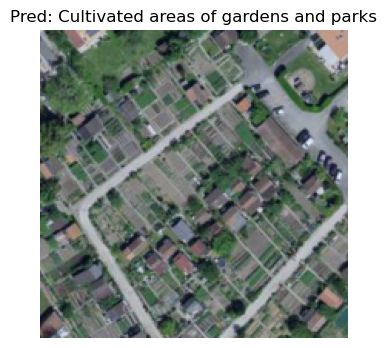

In [6]:
# ---- Display image ----
img_vis = img.permute(1, 2, 0).cpu().numpy()
img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min() + 1e-6)
plt.figure(figsize=(4, 4))
plt.imshow(img_vis)
plt.axis('off')
plt.title(f"Pred: {pred_label}")
plt.show()
